# **Inteligencia de negocios - ISIS3301**

# **Proyecto 1 - Analitica de texto**

## **Sección 2**
## **Grupo 23**
*   Rafael Santiago Bastos Russi - *202110792*
*   David Santiago Valderrama Herrera - *201910987*
*   Jesús Alejandro Dávila Pinchao - *202014263*




# **Caso de estudio**

La Organización de las Naciones Unidas (ONU) adopta, el 25 de septiembre del año 2015, la
Agenda 2030i para el desarrollo sostenible, cuyo fin es reducir la pobreza, garantizar acceso
a la salud y educación, buscar igualdad de género y oportunidades, disminuir el impacto
ambiental, entre otros. Esta agenda se basa en 17 objetivos de desarrollo sostenibleii (ODS)
y 169 metas (derivadas de los diferentes ODS).
Dentro del trabajo en conjunto de diferentes entes para alcanzar el cumplimiento de los
ODS, muchas entidades tienen como enfoque el seguimiento y la evaluación de las políticas
públicas y su impacto a nivel social. Este es el caso del Fondo de Poblaciones de las Naciones
Unidas (UNFPAiii) que, junto con entidades públicas y haciendo uso de diferentes
herramientas de participación ciudadana, busca identificar problemas y evaluar soluciones
actuales, relacionando la información con los diferentes ODS. En este contexto, uno de los
procesos que requiere de un mayor esfuerzo es la clasificación de la información textual
que es recopilada, ya que es una tarea que consume gran cantidad recursos y para la cual
se requiere un experto. Es por esto que, en los últimos años, UNFPA ha venido trabajando,
en conjunto con la Universidad de los Andes, en la implementación de diferentes estrategias
de clasificación de textos, que les permitan hacer un análisis automatizado de opiniones
que representan la voz de los habitantes locales sobre problemáticas de su entorno
particular.
Para apoyar a UNFPA en este proceso se ha planteado el primer proyecto del curso, cuyo
objetivo es desarrollar un modelo de clasificación, con técnicas de aprendizaje
automático, que permita relacionar de manera automática un texto según los ODS. Al
igual que desarrollar una aplicación que facilite la interacción con el resultado de dicho
modelo. El modelo podrá ser utilizado entonces para la interpretación y análisis de la
información textual que es recopilada a través de diferentes fuentes por UNFPA en procesos
de planeación participativa para el desarrollo a nivel territorial.

#**Etapa 1**

## **1. Importación de librerias**

In [1]:
!pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=834eeaa5c0f9118971c30ad7ea1571e001fe0b8e8d287f984a2690b9689bddc0
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import pandas as pd
import numpy as np
import sys
import re, string, unicodedata

import inflect
import nltk
import spacy
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Versiones anteriores a 1.2 de sklearn: from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from num2words import num2words
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from joblib import dump, load

#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns


In [3]:
!python -m spacy download es_core_news_sm

2023-11-03 03:26:05.078958: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 03:26:05.079039: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 03:26:05.079095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 03:26:06.323685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 57.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


## **2. Perfilamiento y entendimiento de los datos**

### **2.1. Lectura de los datos**

In [4]:
data=pd.read_excel('./data/cat_345.xlsx')
# Asignación a una nueva variable de los datos leidos

### **2.2. Entendimiento de los datos**

In [ ]:
data.shape

(3000, 2)

In [ ]:
data.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


In [ ]:
data.dtypes

Textos_espanol    object
sdg                int64
dtype: object

In [ ]:
data.describe()

,sdg
count,3000.000000
mean,4.000000
std,0.816633
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [ ]:
pd.value_counts(data['sdg'])

sdg
3    1000
4    1000
5    1000
Name: count, dtype: int64

In [ ]:
data.isnull().sum()

Textos_espanol    0
sdg               0
dtype: int64

In [ ]:
data.duplicated(keep = False).sum()

0

## **3. Preparación de los datos**

Se realizaran las siguientes actividades para una adecuada preparación de los datos:



*   Limpieza de los datos.
*   Tokenización.
*   Normalización.

Usando las librerias spacy para el procesamiento de las palabras incluyendo su lematización y verificación de números, unicodedata para eliminar caracteres especiales y num2words para convertir numeros en palabras


## **3.1. Limpieza y tokenización**

In [42]:
data_t = data.copy()

In [43]:
nlp = spacy.load('es_core_news_sm')

Se carga el modulo para español de spacy

In [68]:
def es_entero(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

def es_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [44]:
texts = data_t['Textos_espanol']
tokens = []

stop_words = nlp.Defaults.stop_words  #Stop words en español
cont = 0
for opinion in texts:
  opinionP = opinion.lower() #Se pone el texto en minusculas
  opinionP = unicodedata.normalize('NFKD', opinionP).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  #Se quitan caracteres especiales
  opinionDoc = nlp(opinionP) #Se crea un doc con npl para procesar el texto
  tokensI = []
  for word in opinionDoc:
    wordP = re.sub(r'[^\w\s]', '', word.text) #Remover signos de puntuación
    if wordP != '':
      if wordP == "15.7":
           print(wordP)
      if (es_float(word.text)) or (es_entero(word.text)):
        #print(wordP)

        num_word = num2words(wordP, lang='es')
        #print(num_word)
        tokensI.append(num_word)
        if cont == 5:
           print(wordP)
           print(num_word)

      else:
        if word.text not in stop_words: #No se tienen en cuenta las stop words
            tokensI.append(word.lemma_) #Se toma en cuenta solo el lemma de la palabra
  cont+=1
  tokens.append(tokensI)

2013
dos mil trece


In [45]:
data_t['words'] = pd.Series(tokens, copy=False)
data_t.head()

,Textos_espanol,sdg,words
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[ejemplo, naomero, consulta, externo, especial..."
1,"En 2007, el gobierno central financió directam...",3,"[dos mil siete, gobierno, central, financio, d..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factor, juego, particular, varied..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, agencia, prom..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estimar, 15.7, litro..."


In [ ]:
data_t["words"].dtype

dtype('O')

In [9]:
datix = data_t["words"]

## **3.2. Normalización**

In [46]:
data_t['words'] = data_t['words'].apply(lambda x: ' '.join(map(str, x)))
data_t

,Textos_espanol,sdg,words
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,ejemplo naomero consulta externo especialista ...
1,"En 2007, el gobierno central financió directam...",3,dos mil siete gobierno central financio direct...
2,"Claramente, hay muchos otros factores en juego...",3,claramente factor juego particular variedad ba...
3,"Por ejemplo, el estado australiano de Victoria...",3,ejemplo australiano victoria agencia promocion...
4,"El consumo anual de alcohol se estima en 15,7 ...",3,consumo anual alcohol estimar 15.7 litro ano h...
...,...,...,...
2995,Un caucus efectivo se basa en fuertes vínculos...,5,caucus efectivo basar fuerte vinculo grupo nac...
2996,"Por el contrario, el porcentaje de hogares en ...",5,contrario porcentaje hogar edad trabajar hombr...
2997,El análisis utilizará una gama de medidas que ...,5,analisis utilizar gama medida reflejar barrera...
2998,"La capacitación económica, el apoyo y, a veces...",5,capacitacion economico apoyo incentivo abordar...


In [ ]:
data_t["words"].dtype

dtype('O')

In [47]:
X_data, Y_data = data_t['words'], data_t['sdg'].astype(int)

In [48]:
tf_idf = TfidfVectorizer(max_features=3000)
X_data = tf_idf.fit_transform(X_data)

print(X_data.shape)
X_data.toarray()[0]

(3000, 3000)


array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.05635192])

Para normalizar se usa un vectorizador TF-IDF, quedando la variable predictora en Y_data y los textos en X_data

# **4. Modelos de clasificación**

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)

## **4.1. Primer modelo: Árbol de decisión**

In [51]:
clf = DecisionTreeClassifier(criterion = 'entropy',random_state = 0)

### 4.1.1. **Modelo de Prueba**

In [52]:
clf.fit(X_test, y_test)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [53]:
# Predecir las categorías en el conjunto de entrenamiento
y_pred_test = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
print(f'Precisión: {accuracy}')

report = classification_report(y_test, y_pred_test)
print(report)

Precisión: 1.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       187
           5       1.00      1.00      1.00       176

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



Se observa todas las estadisticas en 1, esto puede indicar que el modelo puede no estar haciendo bien la predicción por algun sesgo o sobreajuste en los datos

### 4.1.2. Nivel de importancia de cada feature

In [54]:
importancia= clf.feature_importances_
importancia

array([0., 0., 0., ..., 0., 0., 0.])

In [55]:
pd.Series(clf.feature_importances_, index=tf_idf.vocabulary_).sort_values(ascending = True).tail(30)

aislamiento         0.003826
atributo            0.003959
23                  0.004134
revisión            0.004239
iniciar             0.004653
seguido             0.005396
inclusiva           0.006540
monitoreo           0.007150
maestro             0.008593
conocimiento        0.008791
procedente          0.009317
etnia               0.010054
heroina             0.011318
sida                0.011655
guia                0.011833
involuntario        0.011872
actual              0.013289
cuidador            0.013566
parlamentario       0.015244
aprendiz            0.016028
estratificacion     0.016200
prioritario         0.020190
administracion      0.021211
dieciséis           0.037524
participacion       0.049850
tradicionalmente    0.060439
articulo            0.072978
publicacion         0.100792
observación         0.129165
recopilado          0.292955
dtype: float64

Observamos que incluso un numero como "dieciseis" tiene mas importancia que una palabra fundamental como lo es "estratificación" por lo cual vemos que los numeros en este caso no aportan una buena predicción en el modelo.

In [77]:
data_M = data.copy()

In [81]:
texts = data_M['Textos_espanol']
tokensN = []


cont = 0
for opinion in texts:
  opinionP = opinion.lower() #Se pone el texto en minusculas
  opinionP = unicodedata.normalize('NFKD', opinionP).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  #Se quitan caracteres especiales
  opinionDoc = nlp(opinionP) #Se crea un doc con npl para procesar el texto
  tokensIN = []
  for word in opinionDoc:
    wordP = re.sub(r'[^\w\s]', '', word.text) #Remover signos de puntuación
    if wordP != '':
      if ((((es_float(word.lemma_)) or (es_entero(word.lemma_))) != True) and (word.text not in stop_words)): #No se tienen en cuenta las stop words ni los digitos
        if(word.lemma_ == "15.7"):
          print(es_float(word.lemma_))
          print(es_entero(word.lemma_))

        tokensIN.append(word.lemma_) #Se toma en cuenta solo el lemma de la palabra
  cont+=1
  tokensN.append(tokensIN)

In [82]:
data_M['words'] = pd.Series(tokensN, copy=False)
data_M.head()

,Textos_espanol,sdg,words
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"[ejemplo, naomero, consulta, externo, especial..."
1,"En 2007, el gobierno central financió directam...",3,"[gobierno, central, financio, directamente, 0,..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factor, juego, particular, varied..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, agencia, prom..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estimar, litro, ano,..."


In [83]:
data_M['words'] = data_M['words'].apply(lambda x: ' '.join(map(str, x)))
data_M

,Textos_espanol,sdg,words
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,ejemplo naomero consulta externo especialista ...
1,"En 2007, el gobierno central financió directam...",3,"gobierno central financio directamente 0,3% ga..."
2,"Claramente, hay muchos otros factores en juego...",3,claramente factor juego particular variedad ba...
3,"Por ejemplo, el estado australiano de Victoria...",3,ejemplo australiano victoria agencia promocion...
4,"El consumo anual de alcohol se estima en 15,7 ...",3,consumo anual alcohol estimar litro ano hombre...
...,...,...,...
2995,Un caucus efectivo se basa en fuertes vínculos...,5,caucus efectivo basar fuerte vinculo grupo nac...
2996,"Por el contrario, el porcentaje de hogares en ...",5,contrario porcentaje hogar edad trabajar hombr...
2997,El análisis utilizará una gama de medidas que ...,5,analisis utilizar gama medida reflejar barrera...
2998,"La capacitación económica, el apoyo y, a veces...",5,capacitacion economico apoyo incentivo abordar...


In [84]:
X_data, Y_data = data_M['words'], data_M['sdg'].astype(int)

In [85]:
tf_idf = TfidfVectorizer(max_features=3000)
X_data = tf_idf.fit_transform(X_data)

print(X_data.shape)
X_data.toarray()[0]

(3000, 3000)


array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.05781194])

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)

In [87]:
clfN = DecisionTreeClassifier(criterion = 'entropy',random_state = 0)

In [88]:
clfN.fit(X_test, y_test)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [89]:
# Predecir las categorías en el conjunto de entrenamiento
y_pred_test = clfN.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test)
print(f'Precisión: {accuracy}')

report = classification_report(y_test, y_pred_test)
print(report)

Precisión: 1.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       187
           5       1.00      1.00      1.00       176

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [90]:
importancia= clfN.feature_importances_
importancia

array([0., 0., 0., ..., 0., 0., 0.])

In [91]:
pd.Series(clfN.feature_importances_, index=tf_idf.vocabulary_).sort_values(ascending = True).tail(30)

innovadora       0.004134
desafio          0.004584
cualidad         0.004653
eds              0.006403
ocupación        0.006540
quirurgico       0.006596
grave            0.006651
controlar        0.007150
procedente       0.008098
atribuible       0.008738
australia        0.008783
alcanzar         0.008791
explicar         0.009445
par              0.010318
actual           0.010951
conllevar        0.011579
negativamente    0.011595
razon            0.011876
financiado       0.012475
compartido       0.013719
valoracion       0.016200
dinero           0.020856
fragmentacion    0.022084
vida             0.037524
comunmente       0.050021
15               0.060410
ejercer          0.072224
gales            0.096951
estr             0.128061
minoritario      0.306845
dtype: float64

#### **Matriz de confusión**

In [92]:
# Se genera la matriz de confusión
cm_test = confusion_matrix(y_test, y_pred_test, labels = clfN.classes_)
cm_test_norm = confusion_matrix(y_test, y_pred_test, labels = clfN.classes_, normalize = 'true')

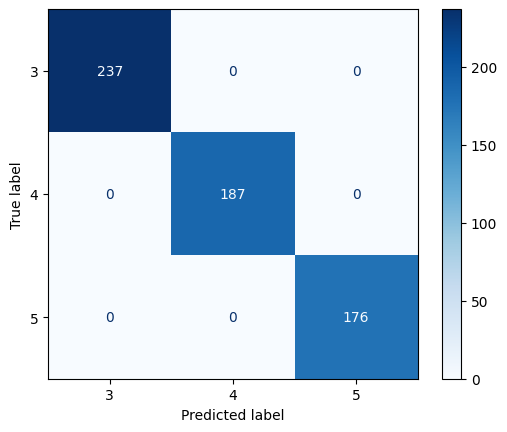

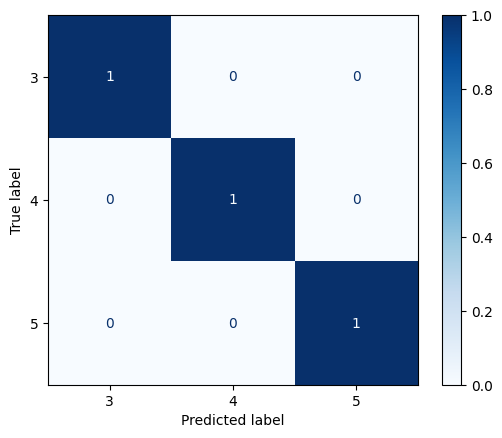

In [93]:
# Se puede visualizar la matriz de confusión
#plot_confusion_matrix(arbol, X_test, Y_test)}
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=clfN.classes_)
disp_test.plot(cmap=plt.cm.Blues)

disp_test_norm = ConfusionMatrixDisplay(confusion_matrix=cm_test_norm, display_labels=clfN.classes_)
disp_test_norm.plot(cmap=plt.cm.Blues)

plt.show()

### 4.1.3. **Modelo de Entrenamiento**

In [94]:
clfN.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [95]:
# Predecir las categorías en el conjunto de entrenamiento
y_pred_train = clfN.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print(f'Precisión: {accuracy}')

report = classification_report(y_train, y_pred_train)
print(report)

Precisión: 1.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       763
           4       1.00      1.00      1.00       813
           5       1.00      1.00      1.00       824

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



#### **Matriz de Confusión**

In [98]:
# Se genera la matriz de confusión
cm_train = confusion_matrix(y_train, y_pred_train, labels = clfN.classes_)
cm_train_norm = confusion_matrix(y_train, y_pred_train, labels = clfN.classes_, normalize = 'true')

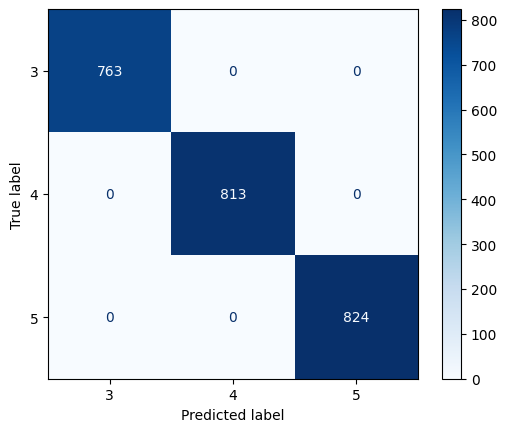

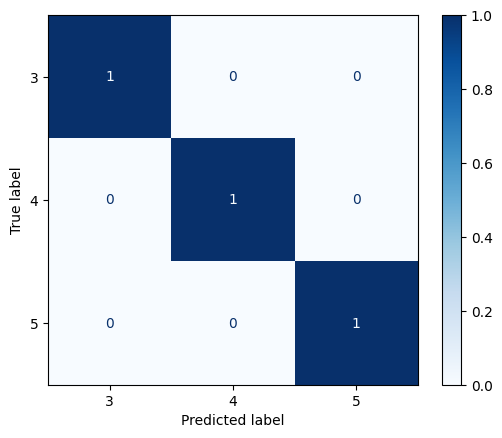

In [100]:
# Visualización de la matriz de confusión

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=clfN.classes_)
disp_train.plot(cmap=plt.cm.Blues)

disp_train_norm = ConfusionMatrixDisplay(confusion_matrix=cm_train_norm, display_labels=clfN.classes_)
disp_train_norm.plot(cmap=plt.cm.Blues)

plt.show()

## **4.2. Segundo modelo: K-Nearest Neighbors (KNN)**

In [101]:
knn_model = KNeighborsClassifier(n_neighbors = 3)

In [102]:
# Entrenamiento del "modelo"
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### **4.2.1. Modelo de Entrenamiento**

In [103]:
# Generación de predicciones para prueba
preds_train = knn_model.predict(X_train)

accuracy = accuracy_score(y_train, preds_train)
print(f'Precisión: {accuracy}')

report = classification_report(y_train, preds_train)
print(report)

Precisión: 0.9725
              precision    recall  f1-score   support

           3       0.96      0.98      0.97       763
           4       0.98      0.98      0.98       813
           5       0.98      0.96      0.97       824

    accuracy                           0.97      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.97      0.97      0.97      2400



#### **Matriz de Confusión**

In [ ]:
# Generación de la matriz de confusión
cm_train = confusion_matrix(y_train, preds_train, labels = knn_model.classes_)
cm_train_norm = confusion_matrix(y_train, preds_train, labels = knn_model.classes_, normalize = 'true')

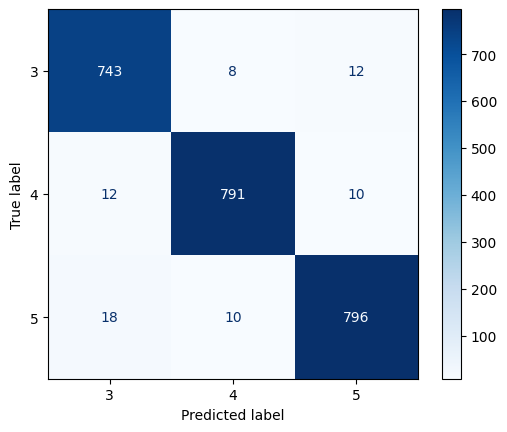

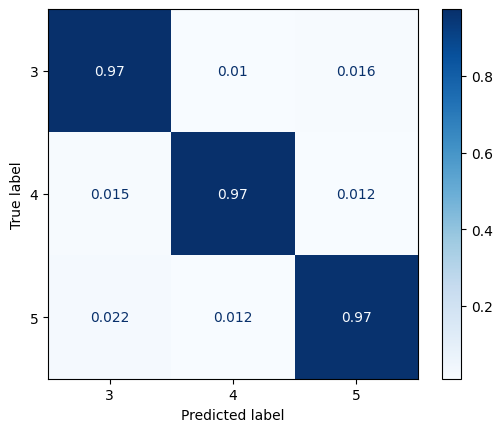

In [ ]:
# Visualización de la matriz
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=knn_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)

disp_train_norm = ConfusionMatrixDisplay(confusion_matrix=cm_train_norm, display_labels=knn_model.classes_)
disp_train_norm.plot(cmap=plt.cm.Blues)

plt.show()

### **4.2.1. Modelo de Prueba**

In [104]:
# Generación de predicciones para prueba
preds_test = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, preds_test)
print(f'Precisión: {accuracy}')

report = classification_report(y_test, preds_test)
print(report)

Precisión: 0.9466666666666667
              precision    recall  f1-score   support

           3       0.97      0.95      0.96       237
           4       0.95      0.94      0.94       187
           5       0.92      0.95      0.93       176

    accuracy                           0.95       600
   macro avg       0.94      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



#### **Matriz de confusión**

In [105]:
# Generación de la matriz de confusión
cm_test = confusion_matrix(y_test, preds_test, labels = knn_model.classes_)
cm_test_norm = confusion_matrix(y_test, preds_test, labels = knn_model.classes_, normalize = 'true')

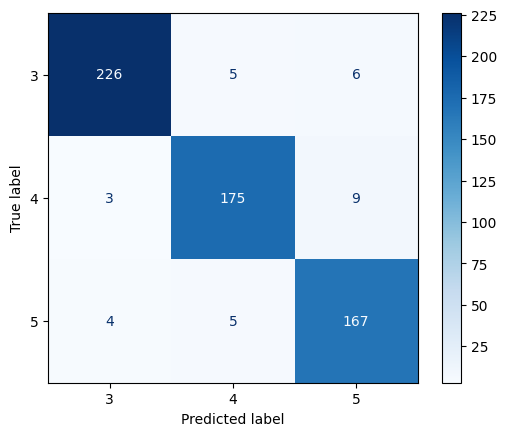

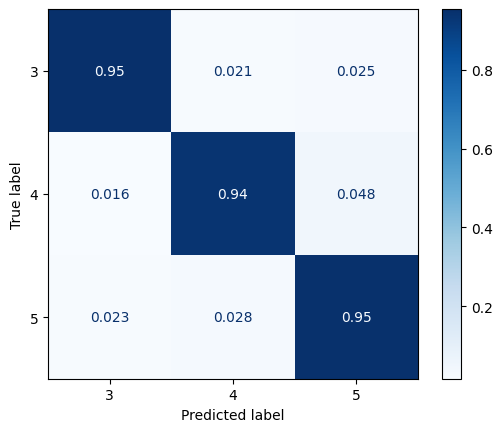

In [106]:
# Visualización de la matriz
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=knn_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)

disp_test_norm = ConfusionMatrixDisplay(confusion_matrix=cm_test_norm, display_labels=knn_model.classes_)
disp_test_norm.plot(cmap=plt.cm.Blues)

plt.show()

## **4.3. Tercer modelo: TF-IDF con Random Forest**

In [107]:
tfidf_model = RandomForestClassifier(random_state=0)

### 4.3.1. **Modelo de Entrenamiento**

In [108]:
tfidf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [109]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 73.0


In [110]:
y_train_tfidf_predict = tfidf_model.predict(X_train)

In [111]:
accuracy = accuracy_score(y_train, y_train_tfidf_predict)
print(f'Precisión: {accuracy}')

report = classification_report(y_train, y_train_tfidf_predict)
print(report)

Precisión: 1.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       763
           4       1.00      1.00      1.00       813
           5       1.00      1.00      1.00       824

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



#### **Matriz de Confusión**

In [112]:
# Generación de la matriz de confusión
cm_train = confusion_matrix(y_train, y_train_tfidf_predict, labels = tfidf_model.classes_)
cm_train_norm = confusion_matrix(y_train, y_train_tfidf_predict, labels = tfidf_model.classes_, normalize = 'true')

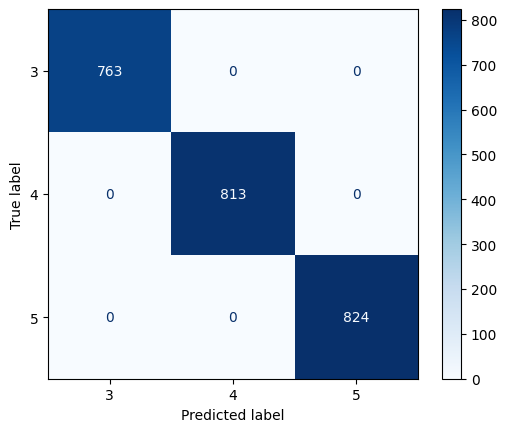

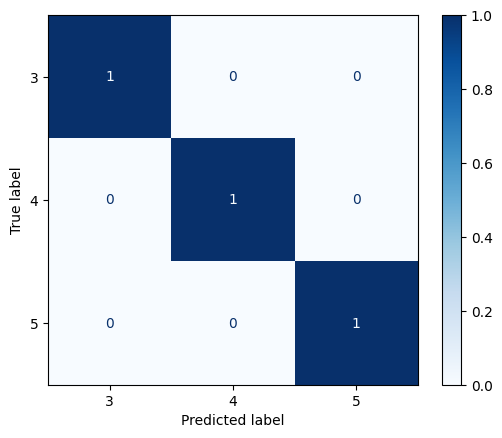

In [113]:
# Visualización de la matriz
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=tfidf_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)

disp_train_norm = ConfusionMatrixDisplay(confusion_matrix=cm_train_norm, display_labels=tfidf_model.classes_)
disp_train_norm.plot(cmap=plt.cm.Blues)

plt.show()

### 4.3.2. Modelo de Prueba

In [114]:
tfidf_model.fit(X_test, y_test)

RandomForestClassifier(random_state=0)

In [115]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 47.01


In [116]:
y_test_tfidf_predict = tfidf_model.predict(X_test)

In [117]:
accuracy = accuracy_score(y_test, y_test_tfidf_predict)
print(f'Precisión: {accuracy}')

report = classification_report(y_test, y_test_tfidf_predict)
print(report)

Precisión: 1.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       187
           5       1.00      1.00      1.00       176

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



#### **Matriz de Confusión**

In [118]:
# Generación de la matriz de confusión
cm_test= confusion_matrix(y_test, y_test_tfidf_predict, labels = tfidf_model.classes_)
cm_test_norm = confusion_matrix(y_test, y_test_tfidf_predict, labels = tfidf_model.classes_, normalize = 'true')

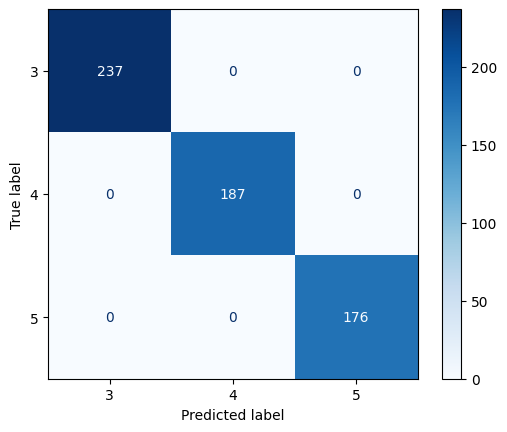

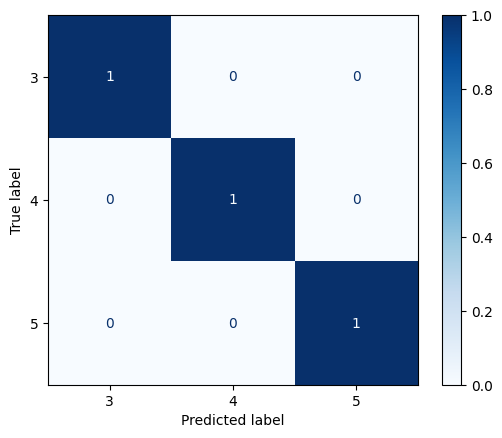

In [119]:
# Visualización de la matriz
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=tfidf_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)

disp_test_norm = ConfusionMatrixDisplay(confusion_matrix=cm_test_norm, display_labels=tfidf_model.classes_)
disp_test_norm.plot(cmap=plt.cm.Blues)

plt.show()

### Nivel de importancia de cada feature

<Axes: >

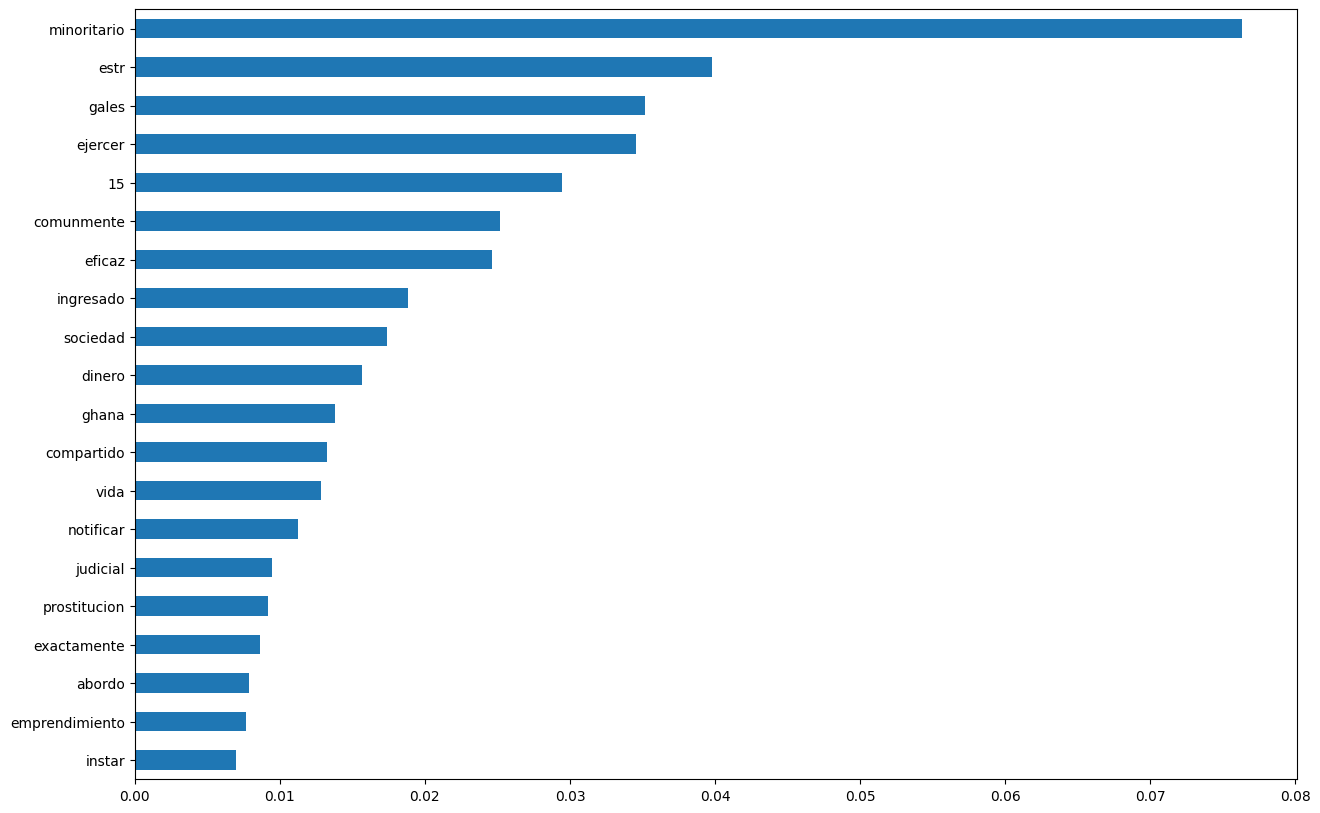

In [120]:
pd.Series(tfidf_model.feature_importances_, index=tf_idf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

# **Persistencia del modelo**

In [121]:
filename = "model.joblib"

In [122]:
dump(knn_model, filename)

['model.joblib']

In [123]:
pipeline_loaded = load(filename)